Cargando los datos y construyendo la serie de tiempo de Cuba

In [173]:
import json

with open("../data/covid19-cuba.json") as fp:
    data = json.load(fp)

cases_per_day = {k:len(v.get('diagnosticados', [])) for k,v in data['casos']['dias'].items()}

ts_cuba = []

t = 0
for _,v in cases_per_day.items():
    t += v
    ts_cuba.append(t)
    
ts_cuba

[3, 3, 4, 4, 4, 5, 7, 11, 16, 25, 35, 40, 48, 57, 67, 80]

Cargando los datos de los demás países (vienen en el mismo formato que tenemos antes)

In [174]:
with open("../data/paises-info-dias.json") as fp:
    countries_data = json.load(fp)

Esta función calcula una "similaridad" entre par de series, la de Cuba, y otra objetivo. En general se usa una media de error computando los residuales día a día y ponderándolos de cierta forma. Los parámetros son:

* `exponent`: $1, 2, ...$ es el exponente de la métrica, e.j., si es $2$ será un error cuadrático medio.
* `normalize`: determina si el residual de cada día se normaliza contra el valor de dicho día. Esto es para lograr, por ejemplo, que una diferencia entre $95$ y $100$ no sea considerada mayor que una diferencia entre $2$ y $4$. Si vale `False` se toman los residuales absolutos.

In [175]:
def similarity(country, exponent=1, normalize=True):
    min_len = min(len(ts_cuba), len(country))
    cuba = ts_cuba[0:min_len]
    country = country[0:min_len]
    
    def metric(vi, vj):
        t = abs(vi - vj)
        b = abs(vi) if normalize else 1
        return (t / b) ** exponent
    
    residuals = [metric(vi, vj) for vi,vj in zip(cuba, country)]
    msqe = sum(residuals) / len(residuals)
    
    return msqe

### Paises

In [668]:
import pandas as pd

countries_stats = pd.read_csv("../data/world_demographics.tsv", sep="\t")
countries_stats

,Country,Population,Yearly change,Net change,Density,Land area,Migrants,Fertility,Med. age,Urban,World share
0,China,"1,439,323,776",0.39,"5,540,090",153,"9,388,211","-348,399",1.7,38,61,18.47
1,India,"1,380,004,385",0.99,"13,586,631",464,"2,973,190","-532,687",2.2,28,35,17.70
2,United States,"331,002,651",0.59,"1,937,734",36,"9,147,420","954,806",1.8,38,83,4.25
3,Indonesia,"273,523,615",1.07,"2,898,047",151,"1,811,570","-98,955",2.3,30,56,3.51
4,Pakistan,"220,892,340",2.00,"4,327,022",287,"770,880","-233,379",3.6,23,35,2.83
...,...,...,...,...,...,...,...,...,...,...,...
230,Montserrat,"4,992",0.06,3,50,100,NaN,N.A.,N.A.,10,0.00
231,Falkland Islands,"3,480",3.05,103,0,"12,170",NaN,N.A.,N.A.,66,0.00
232,Niue,"1,626",0.68,11,6,260,NaN,N.A.,N.A.,46,0.00
233,Tokelau,"1,357",1.27,17,136,10,NaN,N.A.,N.A.,0,0.00


Veamos ahora los países más "parecidos" a Cuba en términos **solamente** de la evolución actual. Nos fijaremos solo en aquellos que tengan al menos `k` días de predicciones más que Cuba.

In [943]:
exponent=1
normalize=True
k = 0
countries_to_analize = [
    'Hungary',
    'Greece',
    'Israel',
    'Dominican Republic',
    'Azerbaijan',
    'Austria',
    'Romania',
    'Croatia',
    'Ecuador',
    'Iceland',
    'Letonia',
    'Iraq',
    'Ireland',
    'Kuwait',
    'Mexico',
    'Moroco',
]

similarities = {
    name: (values, similarity(values, 2, True)) 
    for name,values in countries_data['paises'].items() 
    if len(values) >= k + len(ts_cuba)
    if name in countries_to_analize
}

print("Cuba", "-", ts_cuba)

for i,(values, s) in sorted(similarities.items(), key=lambda t: t[1][1]):
    print(i, s, values[:len(ts_cuba)])

Cuba - [3, 3, 4, 4, 4, 5, 7, 11, 16, 25, 35, 40, 48, 57, 67, 80]
Hungary 0.12615720694784713 [2, 2, 2, 4, 7, 9, 9, 13, 13, 19, 30, 32, 39, 50, 58, 73]
Azerbaijan 0.24374342672345747 [3, 3, 3, 3, 6, 6, 9, 9, 9, 11, 11, 11, 15, 15, 23, 28]
Greece 0.27307935826102786 [1, 3, 4, 4, 7, 7, 7, 9, 31, 45, 46, 73, 73, 89, 99, 99]
Romania 0.29727315166020823 [1, 1, 3, 3, 3, 3, 3, 4, 6, 9, 9, 15, 15, 25, 45, 49]
Croatia 0.30414113520021907 [1, 3, 3, 5, 6, 7, 7, 9, 10, 10, 11, 12, 12, 12, 14, 19]
Mexico 0.3567598362529292 [1, 4, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 8, 12, 12, 26]
Ireland 0.406902208486893 [1, 1, 1, 2, 6, 6, 18, 18, 19, 21, 34, 43, 43, 90, 129, 129]
Israel 0.41580634474511025 [1, 1, 1, 1, 1, 2, 3, 4, 7, 10, 10, 12, 15, 20, 37, 43]
Dominican Republic 0.5783366409893628 [1, 1, 1, 1, 1, 2, 2, 5, 5, 5, 5, 5, 5, 11, 11, 11]
Iraq 0.6647897147389761 [1, 1, 5, 7, 7, 13, 19, 26, 32, 35, 35, 40, 54, 60, 60, 71]
Ecuador 0.9566736972878793 [6, 6, 7, 10, 13, 13, 13, 14, 15, 15, 17, 17, 17, 28, 28, 37]


### Forecast

Vamos a construir un modelo lineal basado en los días anteriores para predecir cada día posterior.
Los parámetros son:

* `step_back`: Cuantos días hacia atrás usar como variables características
* `skip_fraction`: Eliminar el primer $p$ porciento de los valores 
* `min_reports`: Cantidad mínima de reportes que debe haber en un día para usarlo
* `use_values`: Incluir los valores absolutos en las características
* `use_differences`: Incluir las diferencias entre cada par de días consecutivos en las características

In [1000]:
steps_back = 10
skip_fraction = 0.25
min_reports = 1
use_values = True
use_diferences = False

In [1001]:
import numpy as np

def _extract_features(serie, X=None, y=None):
    X = [] if X is None else X
    y = [] if y is None else y
    
    serie = serie[int(skip_fraction * len(serie)):]
    
    for i in range(steps_back, len(serie)):
        features = []
        
        if serie[i] < min_reports:
            continue      
            
        if use_values:
            features.extend(serie[i-steps_back:i])
        if use_diferences:
            for j in range(i-steps_back+1, i):
                features.append(serie[j] - serie[j-1])
            
        current = serie[i]
        
        X.append(features)
        y.append(current)
        
    return X, y

def extract_features(series):
    X = []
    y = []
    
    for country, serie in series.items():
        _extract_features(serie, X, y)
        
    return np.asarray(X), np.asarray(y)

keep_country = 'Hungary' # Dejar fuera para testear luego

X, y = extract_features({
    k:v 
    for k,v in countries_data['paises'].items() 
    if k != keep_country if k in countries_to_analize
})

In [1002]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

In [1003]:
def build_model():
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25)

    lr = Lasso(fit_intercept=False, positive=True, max_iter=10000, tol=0.001)
    lr.fit(Xtrain, ytrain)

    return lr

def predict(model, data, n, previous=1):
    data = list(data)
    result = []

    for i in range(n):
        X, y = _extract_features(data)
        X = X[-previous:]
        y = y[-previous]

        ypred = model.predict(X)
        result.append(ypred[0])
        data.append(ypred[0])
        
    return result

In [1004]:
lr = build_model()
predict(lr, ts_cuba, 7)

[81.34782623102411,
 97.13173281316313,
 98.76819153004321,
 117.93216899109638,
 119.91906987669347,
 143.18694910649967,
 145.59933818082536]

In [1005]:
print(lr.coef_)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.21414666]


In [1006]:
serie = ts_cuba
# serie = countries_data['paises'][keep_country]
previous=1
simulations=15

Y = []
    
for i in range(30):    
    lr = build_model()
    yp = predict(lr, serie, n=simulations, previous=previous)
    yp.insert(0, serie[-previous])
    Y.append(yp)
    
Y = np.asarray(Y)

In [1007]:
ymean = Y.mean(axis=0)
ystdv = Y.std(axis=0)

ymean, ystdv

(array([ 80.        ,  81.73531708,  97.52175239, 100.433134  ,
        118.89350914, 123.32702622, 145.04743159, 151.35178587,
        177.05252438, 185.66236081, 216.21657633, 227.67259891,
        264.14041764, 279.11419724, 322.7847493 , 342.10793687]),
 array([ 0.        ,  0.50474534,  0.60278906,  1.38332643,  1.46970347,
         2.67957953,  2.67471454,  4.44422911,  4.33979417,  6.81540133,
         6.62245177,  9.97737999,  9.72186458, 14.16804971, 13.89395451,
        19.69182863]))

In [1008]:
from matplotlib import pyplot as plt

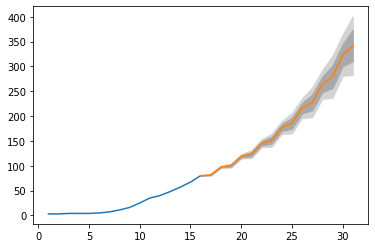

In [1009]:
plt.plot(range(1, len(serie)+1), serie)
plt.plot(range(len(serie)+1-previous, len(serie)+1+len(ymean)-previous), ymean)
plt.fill_between(range(len(serie)+1-previous, len(serie)+1+len(ymean)-previous), 
                 ymean-ystdv*3, 
                 ymean+ystdv*3, 
                 color='lightgrey')
plt.fill_between(range(len(serie)+1-previous, len(serie)+1+len(ymean)-previous), 
                 ymean-ystdv*1.6, 
                 ymean+ystdv*1.6, 
                 color='darkgrey')